In [ ]:
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Building the Dataset class to load the data

In [ ]:

class IrisDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __getitem__(self, index):
      x = torch.Tensor(self.x.iloc[index].values)
      y = self.y[index]
      return x, y

  def __len__(self):
      return self.y.shape[0]

## Shuffling and splitting data

In [ ]:
df = pd.read_csv("./iris.data", sep=",", names=["sepal_length", "sepal_width",
                                                    "petal_legth", "petal_width", "class"])

df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
x = df[["sepal_length", "sepal_width", "petal_legth", "petal_width"]]

y = df["class"]
y = y.to_numpy().reshape(-1, 1)
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(x.shape)
print(y.shape)

(150, 4)
(150,)


In [ ]:
y[6]

2

## Creating the three dataset objects

In [ ]:
train_dataset = IrisDataset(x[0:100], y[0:100])
validation_dataset = IrisDataset(x[100:110], y[100:110])
test_dataset = IrisDataset(x[110:], y[110:])

In [ ]:
train_dataset[5]

(tensor([5.0000, 3.5000, 1.3000, 0.3000]), 0)

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=20,
                          shuffle=True,
                          num_workers=0)

validation_loader = DataLoader(dataset=validation_dataset,
                          batch_size=20,
                          shuffle=True,
                          num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=20,
                          shuffle=True,
                          num_workers=0)

## Test run for batches

In [ ]:
for batch_idx, (x, y) in enumerate(train_loader):
  print(batch_idx, x.shape, y.shape)

0 torch.Size([20, 4]) torch.Size([20])
1 torch.Size([20, 4]) torch.Size([20])
2 torch.Size([20, 4]) torch.Size([20])
3 torch.Size([20, 4]) torch.Size([20])
4 torch.Size([20, 4]) torch.Size([20])


## The classifier

In [ ]:
class IrisClassifier(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(IrisClassifier, self).__init__()

        self.num_classes = num_classes

        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)

    def forward(self, x):

        out = self.linear_1(x)
        out = F.relu(out)

        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    def predict_labels(self, x):
      logits, probas = self.forward(torch.tensor(x, dtype=torch.float))
      Z = np.argmax(probas.detach().numpy(), axis=1)
      return Z

    def evaluate(self, x, y):
      labels = self.predict_labels(x)
      accuracy = torch.sum(torch.tensor(labels, dtype=torch.float).float() == torch.tensor(y, dtype=torch.float).float()).item() / len(y)
      return accuracy



In [ ]:
iris_model = IrisClassifier(num_features=4,
                   num_hidden_1=10,
                   num_classes=3)


optimizer = torch.optim.SGD(iris_model.parameters(), lr=0.01)

In [ ]:
def compute_accuracy(model, data_loader):

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):
          correct_values = 0
          num_examples = 0
          labels = model.predict_labels(features)
          correct_values = torch.sum(torch.tensor(labels, dtype=torch.float).float() == torch.tensor(targets, dtype=torch.float).float())
          correct_values = correct_values
          num_examples += targets.shape[0]
    return (correct_values / num_examples) * 100

## Training

In [ ]:
train_cost = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

num_epochs = 100

for epoch in range(num_epochs):
    print('Epoch:', epoch+1)

    # iris_model.train()
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        logits, probas = iris_model(train_x)

        cost = F.cross_entropy(logits, train_y)

        optimizer.zero_grad()

        cost.backward()

        train_cost.append(cost)

        optimizer.step()

        print(f" | Batch index: {batch_idx} | Batch size: {y.size()[0]} | cost: {cost}")

    # iris_model.eval()
    with torch.no_grad():
      train_acc = compute_accuracy(iris_model, train_loader)
      train_acc_list.append(train_acc.item())

      val_acc = compute_accuracy(iris_model, validation_loader)
      val_acc_list.append(val_acc.item())

      test_acc = compute_accuracy(iris_model, test_loader)
      test_acc_list.append(test_acc.item())

Epoch: 1
 | Batch index: 0 | Batch size: 20 | cost: 1.0781701803207397
 | Batch index: 1 | Batch size: 20 | cost: 1.0426524877548218
 | Batch index: 2 | Batch size: 20 | cost: 1.0765738487243652
 | Batch index: 3 | Batch size: 20 | cost: 1.1140294075012207
 | Batch index: 4 | Batch size: 20 | cost: 1.017788290977478
Epoch: 2
 | Batch index: 0 | Batch size: 20 | cost: 1.0349444150924683
 | Batch index: 1 | Batch size: 20 | cost: 1.0656379461288452
 | Batch index: 2 | Batch size: 20 | cost: 1.0270650386810303
 | Batch index: 3 | Batch size: 20 | cost: 1.0519829988479614
 | Batch index: 4 | Batch size: 20 | cost: 1.040198564529419
Epoch: 3
 | Batch index: 0 | Batch size: 20 | cost: 1.026691198348999
 | Batch index: 1 | Batch size: 20 | cost: 1.0244630575180054
 | Batch index: 2 | Batch size: 20 | cost: 1.0584514141082764
 | Batch index: 3 | Batch size: 20 | cost: 1.0322768688201904
 | Batch index: 4 | Batch size: 20 | cost: 1.012830138206482
Epoch: 4
 | Batch index: 0 | Batch size: 20 | c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 | Batch index: 2 | Batch size: 20 | cost: 1.0044324398040771
 | Batch index: 3 | Batch size: 20 | cost: 1.0300942659378052
 | Batch index: 4 | Batch size: 20 | cost: 1.031246542930603
Epoch: 5
 | Batch index: 0 | Batch size: 20 | cost: 1.0066940784454346
 | Batch index: 1 | Batch size: 20 | cost: 1.0352981090545654
 | Batch index: 2 | Batch size: 20 | cost: 1.0108979940414429
 | Batch index: 3 | Batch size: 20 | cost: 1.0342129468917847
 | Batch index: 4 | Batch size: 20 | cost: 0.9991019368171692
Epoch: 6
 | Batch index: 0 | Batch size: 20 | cost: 1.0155962705612183
 | Batch index: 1 | Batch size: 20 | cost: 0.9961533546447754
 | Batch index: 2 | Batch size: 20 | cost: 0.9871628880500793
 | Batch index: 3 | Batch size: 20 | cost: 1.0227497816085815
 | Batch index: 4 | Batch size: 20 | cost: 0.9926794171333313
Epoch: 7
 | Batch index: 0 | Batch size: 20 | cost: 0.9920503497123718
 | Batch index: 1 | Batch size: 20 | cost: 0.9814068675041199
 | Batch index: 2 | Batch size: 20 | cost: 1

## Plotting

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_accuracy(train_acc_list, valid_acc_list, test_acc_list):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')
    plt.plot(np.arange(1, num_epochs+1),
             test_acc_list, label='Test')


    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()


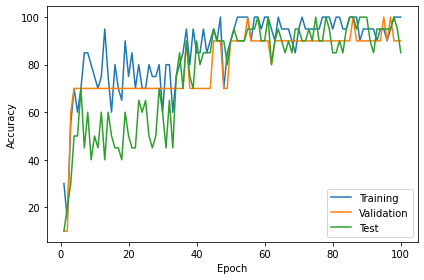

In [ ]:
plot_accuracy(train_acc_list, val_acc_list, test_acc_list)